In [5]:
import numpy as np
import itertools
from beamforming import solve_beamforming_with_selected_antennas
from multiprocessing import Pool
from as_omar import as_omar
# from as_bb import solve_bb, DefaultBranchingPolicy
# from as_bb import ASBBenv as Environment

from as_bb_test import solve_bb, DefaultBranchingPolicy
from as_bb_test import ASBBenv as Environment
import os
import pickle
import time
from pathlib import Path
from antenna_selection.observation import Observation
from model_tester import solve_bb_pool, solve_ml_pool

N = 12
M = 8
max_ant = 4
np.random.seed(seed = 100)
num_egs = 30

ftpl = []
nonftpl = []

folder_path = '/scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/validation_set/N={},M={},L={}_ftpl'.format(N,M,max_ant)

if not os.path.isdir(folder_path):
    Path(folder_path).mkdir(exist_ok=True)

result_filepath = os.path.join(folder_path, 'egs_set_1_seed_100.pkl') 

MODEL_FOLDERPATH = '/scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N={},M={},L={}'.format(N,M,max_ant)

num_nodes_eval = 0
time_total = 0
obj_bb = 0
obj_omar = 0
obj_opt = 0
t1 = time.time()

instances = np.random.randn(num_egs, 2, N, M)

######### ORACLE method #####################

# t1 = time.time()
# arguments_oracle = list(zip(list(instances), [max_ant]*num_egs))
# # with Pool(10) as p:
# #     out_oracle = p.map(solve_bb_pool, arguments_oracle)
# #     print('pool ended')
# # oracle_time = time.time() - t1
# out_oracle =[]
# for i in range(num_egs):
#     print('eg {}'.format(i))
#     output = solve_bb_pool(arguments_oracle[i])
#     out_oracle.append(output)

# optimal_solution_list = [out_oracle[i][0] for i in range(len(out_oracle))]
# optimal_objective_list = [out_oracle[i][1] for i in range(len(out_oracle))]
# oracle_time = np.mean([out_oracle[i][3] for i in range(len(out_oracle))])

# data = (instances, optimal_solution_list, optimal_objective_list, oracle_time)
# with open(result_filepath, 'wb') as handle:
#     pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)    

########### LOAD data ################################################

with open(result_filepath, 'rb') as handle:
    data = pickle.load(handle)
    instances, optimal_solution_list, optimal_objective_list, oracle_time = data

########## OMAR'S Method #######################################
# mask_omar = []
# omar_time = 0
# for i in range(num_egs):
#     H = instances[i,0,:,:] + 1j*instances[i,1,:,:]
#     obj_bb += optimal_objective_list[i]
#     t1 = time.time()
#     obj, mask = as_omar(H, max_ant=max_ant)
#     omar_time += time.time() - t1
#     obj_omar += obj
#     mask_omar.append(mask)
# omar_time = omar_time/num_egs
# print(omar_time)


########### GNN MODEL ###################################


### FTPL ###
mask_omar = [np.zeros(N)]*num_egs
for i in range(4, 5):
    MODEL_FILEPATH = os.path.join(MODEL_FOLDERPATH, 'gnn_ftpl3_iter_{}'.format(i))
    t1 = time.time()
    arguments_ml = list(zip(list(instances), optimal_solution_list, optimal_objective_list, range(num_egs), [MODEL_FILEPATH]*num_egs, [max_ant]*num_egs, mask_omar, [False]*num_egs))
    
    out_ml =[]
    for i in range(num_egs):
        print('eg {}'.format(i))
        output = solve_ml_pool(arguments_ml[i])
        out_ml.append(output)

#     with Pool(30) as p:
#         out_ml = p.map(solve_ml_pool, arguments_ml)
    
    avg_ml_ogap = np.mean(np.array([out_ml[i][1] for i in range(len(out_ml))]))
    avg_ml_steps = np.mean(np.array([out_ml[i][0] for i in range(len(out_ml))]))
    ml_time = np.mean(np.array([out_ml[i][2] for i in range(len(out_ml))]))
    ftpl.append((avg_ml_ogap, avg_ml_steps, ml_time))

### NON-FTPL ###
# for i in range(19, 20):
#     MODEL_FILEPATH = os.path.join(MODEL_FOLDERPATH, 'gnn_nonftpl_iter_{}'.format(i))
#     t1 = time.time()
#     arguments_ml = list(zip(list(instances), optimal_solution_list, optimal_objective_list, range(num_egs), [MODEL_FILEPATH]*num_egs, [max_ant]*num_egs, mask_omar))
    
#     out_ml =[]
#     for i in range(num_egs):
#         print('eg {}'.format(i))
#         output = solve_ml_pool(arguments_ml[i])
#         out_ml.append(output)
    
# #     with Pool(10) as p:
# #         out_ml = p.map(solve_ml_pool, arguments_ml)
    
#     avg_ml_ogap = np.mean(np.array([out_ml[i][1] for i in range(len(out_ml))]))
#     avg_ml_steps = np.mean(np.array([out_ml[i][0] for i in range(len(out_ml))]))
#     ml_time = np.mean(np.array([out_ml[i][2] for i in range(len(out_ml))]))
#     nonftpl.append((avg_ml_ogap, avg_ml_steps, ml_time))

# mydict = {'ftpl': ftpl, 'nonftpl': nonftpl, 'omar':(omar_time, oracle_time, obj_omar, obj_bb)}
# output = open('ftpl_nonftpl_test.pkl', 'wb')
# pickle.dump(mydict, output)
# output.close()   


eg 0
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=12,M=8,L=4/gnn_ftpl3_iter_4


/scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/as_bb_test.py:436: RuntimeWarning: invalid value encountered in double_scalars
  if (self.global_U - self.global_L)/abs(self.global_U) < self.epsilon:


timestep 0
Selection Time 4.76837158203125e-07
Prune Decision Time 0.006524562835693359


/scratch/sagar/Projects/combopt/venv/lib/python3.6/site-packages/cvxpy/reductions/solvers/solving_chain.py:167: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


Push children Time 0.6376006603240967
timestep 1
Selection Time 7.152557373046875e-07
Prune Decision Time 0.0036978721618652344
Push children Time 0.615776538848877
timestep 2
Selection Time 7.152557373046875e-07
Prune Decision Time 0.003291606903076172
Push children Time 0.5034067630767822
timestep 3
Selection Time 4.76837158203125e-07
Prune Decision Time 0.003269195556640625
Push children Time 0.4283313751220703
timestep 4
Selection Time 7.152557373046875e-07
Prune Decision Time 0.003161907196044922
timestep 4
Selection Time 9.5367431640625e-07
Prune Decision Time 0.0024373531341552734
timestep 4
Selection Time 7.152557373046875e-07
Prune Decision Time 0.002331972122192383
Push children Time 0.4736924171447754
timestep 5
Selection Time 4.76837158203125e-07
Prune Decision Time 0.003324270248413086
timestep 5
Selection Time 9.5367431640625e-07
Prune Decision Time 0.0028378963470458984
timestep 5
Selection Time 4.76837158203125e-07
Prune Decision Time 0.002794027328491211
Push children 

Push children Time 0.46059441566467285
timestep 39
Selection Time 4.76837158203125e-07
Prune Decision Time 0.003022909164428711
timestep 39
Selection Time 9.5367431640625e-07
Prune Decision Time 0.0027658939361572266
timestep 39
Selection Time 9.5367431640625e-07
Prune Decision Time 0.0025849342346191406
timestep 39
Selection Time 7.152557373046875e-07
Prune Decision Time 0.0023627281188964844
Push children Time 0.5171380043029785
timestep 40
Selection Time 7.152557373046875e-07
Prune Decision Time 0.003304719924926758
Push children Time 0.3880791664123535
timestep 41
Selection Time 9.5367431640625e-07
Prune Decision Time 0.002659320831298828
Push children Time 0.45055341720581055
timestep 42
Selection Time 7.152557373046875e-07
Prune Decision Time 0.008845329284667969
timestep 42
Selection Time 9.5367431640625e-07
Prune Decision Time 0.002796173095703125
Push children Time 0.4758732318878174
timestep 43
Selection Time 4.76837158203125e-07
Prune Decision Time 0.003260374069213867
Push 

Push children Time 0.41480350494384766
timestep 33
Selection Time 9.5367431640625e-07
Prune Decision Time 0.0028336048126220703
Push children Time 0.5112547874450684
timestep 34
Selection Time 7.152557373046875e-07
Prune Decision Time 0.003306865692138672
Push children Time 0.4231443405151367
timestep 35
Selection Time 4.76837158203125e-07
Prune Decision Time 0.0031585693359375
Push children Time 0.39725232124328613
timestep 36
Selection Time 4.76837158203125e-07
Prune Decision Time 0.003185749053955078
Push children Time 0.42119860649108887
timestep 37
Selection Time 4.76837158203125e-07
Prune Decision Time 0.0032570362091064453
Push children Time 0.47181057929992676
timestep 38
Selection Time 9.5367431640625e-07
Prune Decision Time 0.002811431884765625
Push children Time 0.37390947341918945
timestep 39
Selection Time 4.76837158203125e-07
Prune Decision Time 0.0032300949096679688
Push children Time 0.362795352935791
timestep 40
Selection Time 4.76837158203125e-07
Prune Decision Time 0

Push children Time 0.39302539825439453
timestep 26
Selection Time 7.152557373046875e-07
Prune Decision Time 0.0034275054931640625
Push children Time 0.4856748580932617
timestep 27
Selection Time 7.152557373046875e-07
Prune Decision Time 0.0030846595764160156
Push children Time 0.4437849521636963
timestep 28
Selection Time 4.76837158203125e-07
Prune Decision Time 0.00310516357421875
timestep 28
Selection Time 9.5367431640625e-07
Prune Decision Time 0.002475738525390625
Push children Time 0.3997204303741455
timestep 29
Selection Time 9.5367431640625e-07
Prune Decision Time 0.003345012664794922
Push children Time 0.4894442558288574
timestep 30
Selection Time 7.152557373046875e-07
Prune Decision Time 0.0030443668365478516
Push children Time 0.43546199798583984
timestep 31
Selection Time 7.62939453125e-06
Prune Decision Time 0.002839326858520508
Push children Time 0.3981146812438965
timestep 32
Selection Time 7.152557373046875e-07
Prune Decision Time 0.0030477046966552734
Push children Time

timestep 0
Selection Time 4.76837158203125e-07
Prune Decision Time 0.002935171127319336
Push children Time 0.5510561466217041
timestep 1
Selection Time 2.384185791015625e-07
Prune Decision Time 0.0032134056091308594
Push children Time 0.5142734050750732
timestep 2
Selection Time 7.152557373046875e-07
Prune Decision Time 0.0031418800354003906
Push children Time 0.4968268871307373
timestep 3
Selection Time 9.5367431640625e-07
Prune Decision Time 0.0028662681579589844
Push children Time 0.3923637866973877
timestep 4
Selection Time 7.152557373046875e-07
Prune Decision Time 0.0031881332397460938
Push children Time 0.45318078994750977
timestep 5
Selection Time 4.76837158203125e-07
Prune Decision Time 0.003272533416748047
Push children Time 0.37774205207824707
timestep 6
Selection Time 4.76837158203125e-07
Prune Decision Time 0.0031652450561523438
Push children Time 0.5070400238037109
timestep 7
Selection Time 4.76837158203125e-07
Prune Decision Time 0.0032799243927001953
Push children Time 0

Push children Time 0.4664924144744873
timestep 20
Selection Time 7.152557373046875e-07
Prune Decision Time 0.0032732486724853516
Push children Time 0.34188342094421387
timestep 21
Selection Time 4.76837158203125e-07
Prune Decision Time 0.003113985061645508
Push children Time 0.45446133613586426
timestep 22
Selection Time 9.5367431640625e-07
Prune Decision Time 0.0024950504302978516
Push children Time 0.47420787811279297
timestep 23
Selection Time 7.152557373046875e-07
Prune Decision Time 0.002947568893432617
Push children Time 0.4716837406158447
timestep 24
Selection Time 7.152557373046875e-07
Prune Decision Time 0.0033156871795654297
timestep 24
Selection Time 9.5367431640625e-07
Prune Decision Time 0.002733945846557617
Push children Time 0.49530553817749023
timestep 25
Selection Time 4.76837158203125e-07
Prune Decision Time 0.003167867660522461
Push children Time 0.48162174224853516
timestep 26
Selection Time 4.76837158203125e-07
Prune Decision Time 0.003083944320678711
timestep 26
S

Push children Time 0.5208256244659424
timestep 23
Selection Time 4.76837158203125e-07
Prune Decision Time 0.0033948421478271484
timestep 23
Selection Time 9.5367431640625e-07
Prune Decision Time 0.002802610397338867
Push children Time 0.37625908851623535
timestep 24
Selection Time 9.5367431640625e-07
Prune Decision Time 0.0026869773864746094
timestep 24
Selection Time 4.76837158203125e-07
Prune Decision Time 0.0028083324432373047
timestep 24
Selection Time 7.152557373046875e-07
Prune Decision Time 0.0025033950805664062
timestep 24
Selection Time 7.152557373046875e-07
Prune Decision Time 0.0025136470794677734
instance result 24 0.0 11.112162113189697 6 5.371181050620627 5.371181050620627
eg 8
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=12,M=8,L=4/gnn_ftpl3_iter_4
timestep 0
Selection Time 2.384185791015625e-07
Prune Decision Time 0.003120899200439453
Push children Time 0.5837411880493164
timestep 1
Selection Time 4.76837158203125e-0

timestep 0
Selection Time 2.384185791015625e-07
Prune Decision Time 0.00295257568359375
Push children Time 0.59256911277771
timestep 1
Selection Time 7.152557373046875e-07
Prune Decision Time 0.002928495407104492
Push children Time 0.5476958751678467
timestep 2
Selection Time 7.152557373046875e-07
Prune Decision Time 0.0031440258026123047
Push children Time 0.5013558864593506
timestep 3
Selection Time 7.152557373046875e-07
Prune Decision Time 0.0027251243591308594
Push children Time 0.47019338607788086
timestep 4
Selection Time 2.384185791015625e-07
Prune Decision Time 0.0032248497009277344
Push children Time 0.5419313907623291
timestep 5
Selection Time 7.152557373046875e-07
Prune Decision Time 0.0033822059631347656
timestep 5
Selection Time 9.5367431640625e-07
Prune Decision Time 0.0025894641876220703
Push children Time 0.4751715660095215
timestep 6
Selection Time 4.76837158203125e-07
Prune Decision Time 0.003319978713989258
timestep 6
Selection Time 1.1920928955078125e-06
Prune Decis

Push children Time 0.45928215980529785
timestep 6
Selection Time 4.76837158203125e-07
Prune Decision Time 0.0029091835021972656
Push children Time 0.5135252475738525
timestep 7
Selection Time 4.76837158203125e-07
Prune Decision Time 0.003092527389526367
Push children Time 0.510451078414917
timestep 8
Selection Time 4.76837158203125e-07
Prune Decision Time 0.0033419132232666016
Push children Time 0.4344363212585449
timestep 9
Selection Time 9.5367431640625e-07
Prune Decision Time 0.0031697750091552734
Push children Time 0.3535637855529785
timestep 10
Selection Time 7.152557373046875e-07
Prune Decision Time 0.0031185150146484375
Push children Time 0.46425628662109375
timestep 11
Selection Time 7.152557373046875e-07
Prune Decision Time 0.0031938552856445312
Push children Time 0.4980316162109375
timestep 12
Selection Time 4.76837158203125e-07
Prune Decision Time 0.0029556751251220703
timestep 12
Selection Time 9.5367431640625e-07
Prune Decision Time 0.002358675003051758
Push children Time 

Push children Time 0.4100065231323242
timestep 50
Selection Time 7.152557373046875e-07
Prune Decision Time 0.0032181739807128906
Push children Time 0.4706275463104248
timestep 51
Selection Time 7.152557373046875e-07
Prune Decision Time 0.0033674240112304688
timestep 51
Selection Time 7.152557373046875e-07
Prune Decision Time 0.002521514892578125
Push children Time 0.5301382541656494
timestep 52
Selection Time 4.76837158203125e-07
Prune Decision Time 0.0035619735717773438
timestep 52
Selection Time 9.5367431640625e-07
Prune Decision Time 0.0023627281188964844
timestep 52
Selection Time 9.5367431640625e-07
Prune Decision Time 0.002417325973510742
timestep 52
Selection Time 4.76837158203125e-07
Prune Decision Time 0.0025947093963623047
Push children Time 0.4216444492340088
timestep 53
Selection Time 4.76837158203125e-07
Prune Decision Time 0.0030815601348876953
timestep 53
Selection Time 7.152557373046875e-07
Prune Decision Time 0.0025811195373535156
instance result 53 73.65393248960747 2

Push children Time 0.4765620231628418
timestep 44
Selection Time 9.5367431640625e-07
Prune Decision Time 0.0029706954956054688
timestep 44
Selection Time 1.1920928955078125e-06
Prune Decision Time 0.002162456512451172
timestep 44
Selection Time 2.384185791015625e-07
Prune Decision Time 0.0024690628051757812
Push children Time 0.3345038890838623
timestep 45
Selection Time 4.76837158203125e-07
Prune Decision Time 0.0029718875885009766
instance result 45 15.878236820641117 21.10119605064392 8 4.153571111035874 4.813084968559885
eg 12
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=12,M=8,L=4/gnn_ftpl3_iter_4
timestep 0
Selection Time 4.76837158203125e-07
Prune Decision Time 0.002853870391845703
Push children Time 0.5753984451293945
timestep 1
Selection Time 7.152557373046875e-07
Prune Decision Time 0.0029153823852539062
Push children Time 0.5123052597045898
timestep 2
Selection Time 9.5367431640625e-07
Prune Decision Time 0.00288963317871

Push children Time 0.5377867221832275
timestep 14
Selection Time 4.76837158203125e-07
Prune Decision Time 0.003044605255126953
timestep 14
Selection Time 4.76837158203125e-07
Prune Decision Time 0.002440214157104492
Push children Time 0.5455396175384521
timestep 15
Selection Time 4.76837158203125e-07
Prune Decision Time 0.0030412673950195312
timestep 15
Selection Time 4.76837158203125e-07
Prune Decision Time 0.0024373531341552734
Push children Time 0.4756336212158203
timestep 16
Selection Time 7.152557373046875e-07
Prune Decision Time 0.002803802490234375
timestep 16
Selection Time 4.76837158203125e-07
Prune Decision Time 0.002315521240234375
Push children Time 0.5068135261535645
timestep 17
Selection Time 4.76837158203125e-07
Prune Decision Time 0.002847433090209961
Push children Time 0.4801924228668213
timestep 18
Selection Time 1.1920928955078125e-06
Prune Decision Time 0.0032083988189697266
timestep 18
Selection Time 1.1920928955078125e-06
Prune Decision Time 0.002712726593017578
P

Push children Time 0.45593881607055664
timestep 5
Selection Time 7.152557373046875e-07
Prune Decision Time 0.0028350353240966797
Push children Time 0.4342474937438965
timestep 6
Selection Time 7.152557373046875e-07
Prune Decision Time 0.002385377883911133
Push children Time 0.4373018741607666
timestep 7
Selection Time 7.152557373046875e-07
Prune Decision Time 0.0024843215942382812
Push children Time 0.4803183078765869
timestep 8
Selection Time 4.76837158203125e-07
Prune Decision Time 0.002932310104370117
Push children Time 0.42359447479248047
timestep 9
Selection Time 7.152557373046875e-07
Prune Decision Time 0.0028166770935058594
Push children Time 0.4057304859161377
timestep 10
Selection Time 2.384185791015625e-07
Prune Decision Time 0.0029604434967041016
Push children Time 0.5928289890289307
timestep 11
Selection Time 4.76837158203125e-07
Prune Decision Time 0.0030128955841064453
Push children Time 0.438490629196167
timestep 12
Selection Time 4.76837158203125e-07
Prune Decision Time

Push children Time 0.45525121688842773
timestep 28
Selection Time 4.76837158203125e-07
Prune Decision Time 0.003304719924926758
Push children Time 0.5774662494659424
timestep 29
Selection Time 1.430511474609375e-06
Prune Decision Time 0.0034401416778564453
timestep 29
Selection Time 1.1920928955078125e-06
Prune Decision Time 0.002689361572265625
timestep 29
Selection Time 9.5367431640625e-07
Prune Decision Time 0.002656221389770508
Push children Time 0.5208797454833984
timestep 30
Selection Time 7.152557373046875e-07
Prune Decision Time 0.0031290054321289062
Push children Time 0.4660923480987549
timestep 31
Selection Time 9.5367431640625e-07
Prune Decision Time 0.0030333995819091797
Push children Time 0.6770858764648438
timestep 32
Selection Time 9.5367431640625e-07
Prune Decision Time 0.004430294036865234
timestep 32
Selection Time 1.4066696166992188e-05
Prune Decision Time 0.0031485557556152344
timestep 32
Selection Time 1.430511474609375e-06
Prune Decision Time 0.0030884742736816406

Push children Time 0.47571539878845215
timestep 25
Selection Time 7.152557373046875e-07
Prune Decision Time 0.003076314926147461
Push children Time 0.41089677810668945
timestep 26
Selection Time 4.76837158203125e-07
Prune Decision Time 0.003104686737060547
Push children Time 0.4547767639160156
timestep 27
Selection Time 7.152557373046875e-07
Prune Decision Time 0.0030705928802490234
Push children Time 0.5203375816345215
timestep 28
Selection Time 4.76837158203125e-07
Prune Decision Time 0.0030639171600341797
Push children Time 0.46086573600769043
timestep 29
Selection Time 4.76837158203125e-07
Prune Decision Time 0.0031332969665527344
Push children Time 0.4151334762573242
timestep 30
Selection Time 4.76837158203125e-07
Prune Decision Time 0.0028276443481445312
Push children Time 0.5084640979766846
timestep 31
Selection Time 4.76837158203125e-07
Prune Decision Time 0.003297090530395508
Push children Time 0.3922150135040283
timestep 32
Selection Time 7.152557373046875e-07
Prune Decision 

Push children Time 0.36400866508483887
timestep 67
Selection Time 9.5367431640625e-07
Prune Decision Time 0.002684354782104492
timestep 67
Selection Time 1.1920928955078125e-06
Prune Decision Time 0.0021448135375976562
timestep 67
Selection Time 9.5367431640625e-07
Prune Decision Time 0.0021102428436279297
timestep 67
Selection Time 7.152557373046875e-07
Prune Decision Time 0.0021200180053710938
Push children Time 0.5416529178619385
timestep 68
Selection Time 7.152557373046875e-07
Prune Decision Time 0.003122568130493164
instance result 68 0.0 32.18696594238281 9 2.7678068220727696 2.7678068220727696
eg 18
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=12,M=8,L=4/gnn_ftpl3_iter_4
timestep 0
Selection Time 9.5367431640625e-07
Prune Decision Time 0.003216266632080078
Push children Time 0.5826015472412109
timestep 1
Selection Time 9.5367431640625e-07
Prune Decision Time 0.004034519195556641
Push children Time 0.5399367809295654
timestep 

Push children Time 0.5868844985961914
timestep 1
Selection Time 7.152557373046875e-07
Prune Decision Time 0.003016233444213867
Push children Time 0.5096862316131592
timestep 2
Selection Time 7.152557373046875e-07
Prune Decision Time 0.003227710723876953
Push children Time 0.4955637454986572
timestep 3
Selection Time 4.76837158203125e-07
Prune Decision Time 0.0032303333282470703
Push children Time 0.3883647918701172
timestep 4
Selection Time 4.76837158203125e-07
Prune Decision Time 0.0030813217163085938
Push children Time 0.49167823791503906
timestep 5
Selection Time 4.76837158203125e-07
Prune Decision Time 0.0031783580780029297
timestep 5
Selection Time 9.5367431640625e-07
Prune Decision Time 0.0025234222412109375
timestep 5
Selection Time 7.152557373046875e-07
Prune Decision Time 0.0024881362915039062
timestep 5
Selection Time 1.1920928955078125e-06
Prune Decision Time 0.0022919178009033203
Push children Time 0.539665937423706
timestep 6
Selection Time 2.384185791015625e-07
Prune Deci

Push children Time 0.40537071228027344
timestep 35
Selection Time 9.5367431640625e-07
Prune Decision Time 0.0026009082794189453
Push children Time 0.4528367519378662
timestep 36
Selection Time 9.5367431640625e-07
Prune Decision Time 0.002840280532836914
Push children Time 0.45678043365478516
timestep 37
Selection Time 2.384185791015625e-07
Prune Decision Time 0.003180265426635742
timestep 37
Selection Time 7.152557373046875e-07
Prune Decision Time 0.002740144729614258
Push children Time 0.4935173988342285
timestep 38
Selection Time 7.152557373046875e-07
Prune Decision Time 0.0026655197143554688
timestep 38
Selection Time 4.76837158203125e-07
Prune Decision Time 0.0021517276763916016
Push children Time 0.38022398948669434
timestep 39
Selection Time 9.5367431640625e-07
Prune Decision Time 0.0029697418212890625
Push children Time 0.42563414573669434
timestep 40
Selection Time 7.152557373046875e-07
Prune Decision Time 0.0031769275665283203
Push children Time 0.3988933563232422
timestep 41


Push children Time 0.38489460945129395
timestep 9
Selection Time 4.76837158203125e-07
Prune Decision Time 0.0035169124603271484
timestep 9
Selection Time 9.5367431640625e-07
Prune Decision Time 0.002340078353881836
Push children Time 0.5054254531860352
timestep 10
Selection Time 1.430511474609375e-06
Prune Decision Time 0.002669811248779297
timestep 10
Selection Time 1.1920928955078125e-06
Prune Decision Time 0.00243377685546875
Push children Time 0.5110747814178467
timestep 11
Selection Time 4.76837158203125e-07
Prune Decision Time 0.0030698776245117188
timestep 11
Selection Time 1.1920928955078125e-06
Prune Decision Time 0.0023050308227539062
Push children Time 0.5232462882995605
timestep 12
Selection Time 7.152557373046875e-07
Prune Decision Time 0.004482746124267578
timestep 12
Selection Time 2.384185791015625e-07
Prune Decision Time 0.002695798873901367
Push children Time 0.4329395294189453
timestep 13
Selection Time 7.152557373046875e-07
Prune Decision Time 0.004111051559448242
t

Push children Time 0.36125969886779785
timestep 13
Selection Time 4.76837158203125e-07
Prune Decision Time 0.002892732620239258
Push children Time 0.4827275276184082
timestep 14
Selection Time 4.76837158203125e-07
Prune Decision Time 0.0029196739196777344
Push children Time 0.5129857063293457
timestep 15
Selection Time 2.384185791015625e-07
Prune Decision Time 0.0029883384704589844
Push children Time 0.3745701313018799
timestep 16
Selection Time 4.76837158203125e-07
Prune Decision Time 0.003081798553466797
Push children Time 0.3767664432525635
timestep 17
Selection Time 7.152557373046875e-07
Prune Decision Time 0.0029218196868896484
timestep 17
Selection Time 4.76837158203125e-07
Prune Decision Time 0.0025396347045898438
Push children Time 0.3650486469268799
timestep 18
Selection Time 4.76837158203125e-07
Prune Decision Time 0.0028145313262939453
Push children Time 0.612555980682373
timestep 19
Selection Time 9.5367431640625e-07
Prune Decision Time 0.003103494644165039
Push children Ti

Push children Time 0.4731879234313965
timestep 39
Selection Time 4.76837158203125e-07
Prune Decision Time 0.0027573108673095703
timestep 39
Selection Time 9.5367431640625e-07
Prune Decision Time 0.0021867752075195312
Push children Time 0.33993053436279297
timestep 40
Selection Time 7.152557373046875e-07
Prune Decision Time 0.002933502197265625
timestep 40
Selection Time 7.152557373046875e-07
Prune Decision Time 0.002551555633544922
timestep 40
Selection Time 7.152557373046875e-07
Prune Decision Time 0.0026397705078125
Push children Time 0.4917440414428711
timestep 41
Selection Time 4.76837158203125e-07
Prune Decision Time 0.002933502197265625
timestep 41
Selection Time 4.76837158203125e-07
Prune Decision Time 0.0023670196533203125
timestep 41
Selection Time 7.152557373046875e-07
Prune Decision Time 0.0022394657135009766
instance result 41 32.080673312124894 18.770334720611572 5 3.2073613380006 4.236304450783971
eg 26
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/anten

Push children Time 0.4008631706237793
timestep 42
Selection Time 9.5367431640625e-07
Prune Decision Time 0.0027878284454345703
Push children Time 0.48993587493896484
timestep 43
Selection Time 4.76837158203125e-07
Prune Decision Time 0.0028846263885498047
timestep 43
Selection Time 9.5367431640625e-07
Prune Decision Time 0.002259969711303711
Push children Time 0.6391537189483643
timestep 44
Selection Time 1.1920928955078125e-06
Prune Decision Time 0.0035676956176757812
timestep 44
Selection Time 1.430511474609375e-06
Prune Decision Time 0.002880096435546875
timestep 44
Selection Time 1.1920928955078125e-06
Prune Decision Time 0.0027511119842529297
Push children Time 0.3782064914703369
timestep 45
Selection Time 4.76837158203125e-07
Prune Decision Time 0.0029048919677734375
Push children Time 0.447094202041626
timestep 46
Selection Time 7.152557373046875e-07
Prune Decision Time 0.002874135971069336
timestep 46
Selection Time 4.76837158203125e-07
Prune Decision Time 0.0025129318237304688

Push children Time 0.5588338375091553
timestep 36
Selection Time 7.152557373046875e-07
Prune Decision Time 0.002919435501098633
timestep 36
Selection Time 4.76837158203125e-07
Prune Decision Time 0.0022437572479248047
Push children Time 0.4715242385864258
timestep 37
Selection Time 9.5367431640625e-07
Prune Decision Time 0.0028183460235595703
Push children Time 0.4859931468963623
timestep 38
Selection Time 9.5367431640625e-07
Prune Decision Time 0.0030388832092285156
Push children Time 0.3972039222717285
timestep 39
Selection Time 4.76837158203125e-07
Prune Decision Time 0.003107786178588867
timestep 39
Selection Time 4.76837158203125e-07
Prune Decision Time 0.002475261688232422
Push children Time 0.41323208808898926
timestep 40
Selection Time 9.5367431640625e-07
Prune Decision Time 0.002802610397338867
Push children Time 0.5620653629302979
timestep 41
Selection Time 4.76837158203125e-07
Prune Decision Time 0.003101348876953125
Push children Time 0.4993305206298828
timestep 42
Selectio

Push children Time 0.5397017002105713
timestep 7
Selection Time 9.5367431640625e-07
Prune Decision Time 0.0024230480194091797
timestep 7
Selection Time 9.5367431640625e-07
Prune Decision Time 0.002141714096069336
Push children Time 0.5334649085998535
timestep 8
Selection Time 7.152557373046875e-07
Prune Decision Time 0.0026984214782714844
Push children Time 0.4451904296875
timestep 9
Selection Time 2.384185791015625e-07
Prune Decision Time 0.002854585647583008
Push children Time 0.4290792942047119
timestep 10
Selection Time 7.152557373046875e-07
Prune Decision Time 0.0027761459350585938
Push children Time 0.47385263442993164
timestep 11
Selection Time 7.152557373046875e-07
Prune Decision Time 0.0027420520782470703
timestep 11
Selection Time 4.76837158203125e-07
Prune Decision Time 0.002328634262084961
Push children Time 0.5016071796417236
timestep 12
Selection Time 7.152557373046875e-07
Prune Decision Time 0.0029327869415283203
Push children Time 0.5817549228668213
timestep 13
Selectio

In [ ]:

for i in range(3, 4):
    MODEL_FILEPATH = os.path.join(MODEL_FOLDERPATH, 'gnn_ftpl3_iter_{}'.format(i))
    t1 = time.time()
    arguments_ml = list(zip(list(instances), optimal_solution_list, optimal_objective_list, range(num_egs), [MODEL_FILEPATH]*num_egs, [max_ant]*num_egs, mask_omar, [False]*num_egs))
    
    out_ml =[]
    for i in range(num_egs):
        print('eg {}'.format(i))
        output = solve_ml_pool(arguments_ml[i])
        out_ml.append(output)


In [2]:
out_ml

[(21, -100.0, 10.133156538009644, 0.09302325581395349)]

In [31]:
ftpl

[(0.029194360739263545, 6.133333333333334, 1.8398040850957236)]

In [32]:
nonftpl

[(0.12670382597441848, 5.433333333333334, 2.3564427057902018)]

In [33]:
oracle_time

18.27560358842214

In [40]:
oracle_time/ftpl[0][2]

9.933450923646186

In [41]:
oracle_time/nonftpl[0][2]

7.755590044059085

In [42]:
oracle_time/omar_time

29.263759585789835

In [ ]:
oracle

In [34]:
omar_time

0.6245131810506185

In [37]:
(obj_omar-obj_bb)/(obj_bb)*100

2.36632545782786

In [1]:
import pickle
output = open('ftpl_nonftpl_test.pkl', 'rb')
data = pickle.load(output)

In [2]:
data['ftpl']

[(0.2694953207157567, 5.64, 14.697339482307434)]

In [ ]:
5.64

In [3]:
data['nonftpl']

[(0.16084924055821895, 6.05, 6.8126283812522885)]

In [4]:
data['omar']

(2.7278252387046815, 61.97380712032318, 32.261608724378846, 31.729752941806517)

In [5]:
data['omar'][0]

2.7278252387046815

In [3]:
61.97*1/0.94

65.92553191489363

In [4]:
61.97*1/6.81

9.09985315712188

In [9]:
omar = data['omar']

In [10]:
(omar[2]-omar[3])/omar[3]*100

1.6762052435383632

In [14]:
print(omar_time, obj_omar)
print(ftpl)
print(nonftpl)

NameError: name 'omar_time' is not defined

In [8]:
    
avg_ml_ogap = np.mean(np.array([out_ml[i][1] for i in range(len(out_ml))]))
avg_ml_steps = np.mean(np.array([out_ml[i][0] for i in range(len(out_ml))]))
ml_time = np.mean(np.array([out_ml[i][2] for i in range(len(out_ml))]))
ftpl.append((avg_ml_ogap, avg_ml_steps, ml_time))

### NON-FTPL ###
for i in range(2, 30):
    MODEL_FILEPATH = os.path.join(MODEL_FOLDERPATH, 'gnn_nonftpl_iter_{}'.format(i))
    t1 = time.time()
    arguments_ml = list(zip(list(instances), optimal_solution_list, optimal_objective_list, range(num_egs), [MODEL_FILEPATH]*num_egs, [max_ant]*num_egs, mask_omar))
    
    out_ml =[]
    for i in range(num_egs):
        print('eg {}'.format(i))
        output = solve_ml_pool(arguments_ml[i])
        out_ml.append(output)
    
#     with Pool(num_egs) as p:
#         out_ml = p.map(solve_ml_pool, arguments_ml)
    
    avg_ml_ogap = np.mean(np.array([out_ml[i][1] for i in range(len(out_ml))]))
    avg_ml_steps = np.mean(np.array([out_ml[i][0] for i in range(len(out_ml))]))
    ml_time = np.mean(np.array([out_ml[i][2] for i in range(len(out_ml))]))
    nonftpl.append((avg_ml_ogap, avg_ml_steps, ml_time))
    


/scratch/sagar/Projects/combopt/venv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/scratch/sagar/Projects/combopt/venv/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


eg 0
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=8,M=3,L=5/gnn_nonftpl_iter_2
timestep 0
timestep 1
timestep 2
timestep 2
timestep 3
timestep 3
timestep 4
timestep 4
timestep 5
timestep 5
instance result 5 0.0 5.001058340072632 3 0.2261046114899136 0.2261046114899136
eg 1
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=8,M=3,L=5/gnn_nonftpl_iter_2
timestep 0
timestep 1
timestep 1
timestep 2
timestep 3
timestep 3
timestep 4
timestep 4
instance result 4 0.0 4.802222967147827 4 0.4469534929346341 0.4469534929346341
eg 2
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=8,M=3,L=5/gnn_nonftpl_iter_2
timestep 0
timestep 1
timestep 2
timestep 2
timestep 3
timestep 3
timestep 3
instance result 3 -100.0 3.0615837574005127 3 0.7209357118082166 0.0
eg 3
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_mo

timestep 2
timestep 2
timestep 3
timestep 3
timestep 3
instance result 3 -100.0 1.9247899055480957 3 0.6599860664577335 0.0
eg 29
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=8,M=3,L=5/gnn_nonftpl_iter_2
timestep 0
timestep 1
timestep 1
timestep 2
timestep 3
timestep 3
timestep 4
timestep 4
instance result 4 0.0 2.089869737625122 4 0.29610568105651963 0.29610568105651963
eg 0
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=8,M=3,L=5/gnn_nonftpl_iter_3
timestep 0
timestep 1
timestep 1
timestep 2
timestep 3
timestep 4
timestep 4
timestep 5
instance result 5 0.0 2.2901039123535156 3 0.2261046114899136 0.2261046114899136
eg 1
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=8,M=3,L=5/gnn_nonftpl_iter_3
timestep 0
timestep 1
timestep 2
timestep 2
timestep 3
timestep 3
timestep 4
timestep 5
timestep 6
instance result 6 0.0 2.96105551719665

timestep 0
timestep 1
timestep 1
timestep 2
timestep 2
timestep 3
timestep 4
timestep 5
timestep 6
instance result 6 0.0 5.178603649139404 3 0.553712399584306 0.553712399584306
eg 27
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=8,M=3,L=5/gnn_nonftpl_iter_3
timestep 0
timestep 1
timestep 1
timestep 2
timestep 2
timestep 3
timestep 4
instance result 4 0.0 3.5804502964019775 5 0.34884330791352597 0.34884330791352597
eg 28
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=8,M=3,L=5/gnn_nonftpl_iter_3
timestep 0
timestep 1
timestep 1
timestep 2
timestep 2
timestep 3
instance result 3 0.0 2.9170522689819336 3 0.6599860664577335 0.6599860664577335
eg 29
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=8,M=3,L=5/gnn_nonftpl_iter_3
timestep 0
timestep 1
timestep 2
timestep 2
timestep 3
timestep 3
timestep 4
timestep 5
timestep 6
instance result

timestep 0
timestep 1
timestep 1
timestep 2
timestep 3
timestep 4
timestep 4
timestep 5
timestep 6
timestep 7
timestep 8
timestep 8
instance result 8 0.0 4.207079887390137 7 0.4884241612928177 0.4884241612928177
eg 25
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=8,M=3,L=5/gnn_nonftpl_iter_4
timestep 0
timestep 1
timestep 1
timestep 2
timestep 3
timestep 4
timestep 4
timestep 5
instance result 5 0.0 5.284928798675537 3 0.3463062857297205 0.3463062857297205
eg 26
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=8,M=3,L=5/gnn_nonftpl_iter_4
timestep 0
timestep 1
timestep 1
timestep 2
timestep 2
timestep 3
timestep 4
timestep 5
timestep 6
instance result 6 0.0 6.787407875061035 3 0.553712399584306 0.553712399584306
eg 27
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=8,M=3,L=5/gnn_nonftpl_iter_4
timestep 0
timestep 1
timestep 1
timestep

timestep 0
timestep 1
timestep 1
timestep 2
timestep 2
timestep 3
instance result 3 0.0 1.7958998680114746 3 0.2678400041380617 0.2678400041380617
eg 23
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=8,M=3,L=5/gnn_nonftpl_iter_5
timestep 0
timestep 1
timestep 1
timestep 2
timestep 2
timestep 3
instance result 3 0.0 6.27528190612793 3 0.7310933503543672 0.7310933503543672
eg 24
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=8,M=3,L=5/gnn_nonftpl_iter_5
timestep 0
timestep 1
timestep 1
timestep 2
timestep 3
timestep 4
timestep 4
timestep 5
timestep 6
timestep 7
timestep 8
timestep 8
instance result 8 0.0 3.5724833011627197 7 0.4884241612928177 0.4884241612928177
eg 25
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=8,M=3,L=5/gnn_nonftpl_iter_5
timestep 0
timestep 1
timestep 1
timestep 2
timestep 3
timestep 4
timestep 4
timestep 5
insta

timestep 0
timestep 1
timestep 1
timestep 2
timestep 2
timestep 3
instance result 3 4.406682741966563 3.5861599445343018 4 0.6395397165615243 0.6677222028792629
eg 21
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=8,M=3,L=5/gnn_nonftpl_iter_6
timestep 0
timestep 1
timestep 1
timestep 2
timestep 2
timestep 3
instance result 3 14.828512062145688 3.593911647796631 3 0.4613294167668289 0.5297377049783245
eg 22
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=8,M=3,L=5/gnn_nonftpl_iter_6
timestep 0
timestep 1
timestep 1
timestep 2
timestep 2
timestep 3
instance result 3 0.0 3.1783995628356934 3 0.2678400041380617 0.2678400041380617
eg 23
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=8,M=3,L=5/gnn_nonftpl_iter_6
timestep 0
timestep 1
timestep 1
timestep 2
timestep 2
timestep 3
instance result 3 0.0 2.1117753982543945 3 0.7310933503543672 0

timestep 0
timestep 1
timestep 1
timestep 2
timestep 2
timestep 3
instance result 3 4.683861092749452 4.383201837539673 4 0.43305146726830696 0.4533349964552678
eg 19
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=8,M=3,L=5/gnn_nonftpl_iter_7
timestep 0
timestep 1
timestep 1
timestep 2
timestep 2
timestep 3
instance result 3 0.0 5.57524561882019 3 0.42380208664816094 0.42380208664816094
eg 20
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=8,M=3,L=5/gnn_nonftpl_iter_7
timestep 0
timestep 1
timestep 1
timestep 2
timestep 2
timestep 3
instance result 3 4.406682741966563 6.477862358093262 4 0.6395397165615243 0.6677222028792629
eg 21
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=8,M=3,L=5/gnn_nonftpl_iter_7
timestep 0
timestep 1
timestep 1
timestep 2
timestep 3
timestep 3
timestep 3
timestep 4
instance result 4 14.828512062145688 7.328

timestep 0
timestep 1
timestep 1
timestep 2
timestep 2
timestep 3
instance result 3 0.0 2.806955099105835 3 0.3010937148947479 0.3010937148947479
eg 17
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=8,M=3,L=5/gnn_nonftpl_iter_8
timestep 0
timestep 1
timestep 1
timestep 2
timestep 2
timestep 3
instance result 3 0.0 7.1227500438690186 3 0.5922744365712596 0.5922744365712596
eg 18
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=8,M=3,L=5/gnn_nonftpl_iter_8
timestep 0
timestep 1
timestep 1
timestep 2
timestep 2
timestep 3
instance result 3 4.683861092749452 3.8449392318725586 4 0.43305146726830696 0.4533349964552678
eg 19
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=8,M=3,L=5/gnn_nonftpl_iter_8
timestep 0
timestep 1
timestep 1
timestep 2
timestep 2
timestep 3
instance result 3 0.0 5.408380508422852 3 0.42380208664816094 0.4238020866481

timestep 0
timestep 1
timestep 1
timestep 2
timestep 2
timestep 3
instance result 3 0.0 5.054322004318237 3 0.3694415020818799 0.3694415020818799
eg 15
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=8,M=3,L=5/gnn_nonftpl_iter_9
timestep 0
timestep 1
timestep 1
timestep 2
timestep 2
timestep 3
instance result 3 3.978328720845623 3.3750829696655273 3 0.5053090844738015 0.5254119409104648
eg 16
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=8,M=3,L=5/gnn_nonftpl_iter_9
timestep 0
timestep 1
timestep 1
timestep 2
timestep 2
timestep 3
instance result 3 0.0 4.380200147628784 3 0.3010937148947479 0.3010937148947479
eg 17
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=8,M=3,L=5/gnn_nonftpl_iter_9
timestep 0
timestep 1
timestep 1
timestep 2
timestep 2
timestep 3
instance result 3 0.0 4.191512823104858 3 0.5922744365712596 0.5922744365712596

timestep 2
timestep 2
timestep 3
timestep 4
timestep 5
timestep 6
instance result 7 0.0 6.186583757400513 7 0.31260977567354764 0.31260977567354764
eg 12
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=8,M=3,L=5/gnn_nonftpl_iter_10
timestep 0
timestep 1
timestep 1
timestep 2
timestep 2
timestep 3
instance result 3 2.389557969936682 4.352426290512085 3 0.4040695389614473 0.413725014833787
eg 13
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=8,M=3,L=5/gnn_nonftpl_iter_10
timestep 0
timestep 1
timestep 1
timestep 2
timestep 2
timestep 3
instance result 3 0.0 2.2179617881774902 3 0.6382614540741282 0.6382614540741282
eg 14
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=8,M=3,L=5/gnn_nonftpl_iter_10
timestep 0
timestep 1
timestep 1
timestep 2
timestep 3
timestep 4
timestep 4
timestep 5
timestep 5
instance result 5 0.0 12.691586256027222 3

timestep 0
timestep 1
timestep 1
timestep 2
timestep 2
timestep 3
timestep 4
timestep 5
timestep 6
instance result 7 0.0 3.5433101654052734 7 0.32427892256865337 0.32427892256865337
eg 9
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=8,M=3,L=5/gnn_nonftpl_iter_11
timestep 0
timestep 1
timestep 1
timestep 2
timestep 2
timestep 3
instance result 3 0.0 6.489344358444214 3 0.4328136799378872 0.4328136799378872
eg 10
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=8,M=3,L=5/gnn_nonftpl_iter_11
timestep 0
timestep 1
timestep 1
timestep 2
timestep 2
timestep 3
timestep 4
instance result 4 15.181788855132398 4.885904312133789 3 0.5797439075481874 0.6677594034926472
eg 11
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=8,M=3,L=5/gnn_nonftpl_iter_11
timestep 0
timestep 1
timestep 1
timestep 2
timestep 2
timestep 3
timestep 4
timestep 5
timestep

timestep 2
timestep 2
timestep 3
timestep 4
timestep 5
timestep 6
instance result 7 2.750300875435762 10.684999704360962 3 0.311622422083717 0.3201929762863396
eg 6
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=8,M=3,L=5/gnn_nonftpl_iter_12
timestep 0
timestep 1
timestep 2
timestep 2
timestep 3
timestep 4
timestep 4
timestep 4
timestep 5
timestep 6
timestep 7
timestep 8
timestep 8
instance result 8 0.0 10.150053024291992 6 0.6685170473671693 0.6685170473671693
eg 7
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=8,M=3,L=5/gnn_nonftpl_iter_12
timestep 0
timestep 1
timestep 1
timestep 2
timestep 3
timestep 3
timestep 4
timestep 4
instance result 4 0.0 2.9980480670928955 3 0.5530373504052303 0.5530373504052303
eg 8
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=8,M=3,L=5/gnn_nonftpl_iter_12
timestep 0
timestep 1
timestep 1
timestep 2
t

timestep 0
timestep 1
timestep 1
timestep 2
timestep 3
timestep 3
timestep 4
timestep 5
timestep 6
timestep 7
timestep 8
instance result 8 0.0 10.621245384216309 7 0.7209357118082166 0.7209357118082166
eg 3
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=8,M=3,L=5/gnn_nonftpl_iter_13
timestep 0
timestep 1
timestep 1
timestep 2
timestep 2
timestep 3
timestep 4
timestep 5
timestep 6
instance result 7 0.0 10.795392274856567 7 0.451974904468021 0.451974904468021
eg 4
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=8,M=3,L=5/gnn_nonftpl_iter_13
timestep 0
timestep 1
timestep 1
timestep 2
timestep 2
timestep 3
instance result 3 2.295157834436558 4.388018608093262 3 0.27994546652064045 0.2863706568276389
eg 5
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=8,M=3,L=5/gnn_nonftpl_iter_13
timestep 0
timestep 1
timestep 1
timestep 2
timestep 2
ti

timestep 2
timestep 2
timestep 3
timestep 4
timestep 5
timestep 6
instance result 6 0.0 6.886728763580322 6 0.29610568105651963 0.29610568105651963
eg 0
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=8,M=3,L=5/gnn_nonftpl_iter_14
timestep 0
timestep 1
timestep 1
timestep 2
timestep 2
timestep 3
instance result 3 0.0 4.018709421157837 3 0.2261046114899136 0.2261046114899136
eg 1
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=8,M=3,L=5/gnn_nonftpl_iter_14
timestep 0
timestep 1
timestep 1
timestep 2
timestep 2
timestep 3
timestep 4
timestep 5
timestep 6
instance result 7 0.0 6.647917032241821 7 0.4469534929346341 0.4469534929346341
eg 2
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=8,M=3,L=5/gnn_nonftpl_iter_14
timestep 0
timestep 1
timestep 1
timestep 2
timestep 3
timestep 3
timestep 4
timestep 5
timestep 6
timestep 7
timestep 8
inst

eg 27
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=8,M=3,L=5/gnn_nonftpl_iter_14
timestep 0
timestep 1
timestep 1
timestep 2
timestep 2
timestep 3
timestep 4
timestep 5
timestep 6
instance result 6 0.0 6.992969274520874 6 0.34884330791352597 0.34884330791352597
eg 28
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=8,M=3,L=5/gnn_nonftpl_iter_14
timestep 0
timestep 1
timestep 1
timestep 2
timestep 2
timestep 3
instance result 3 0.0 5.086839199066162 3 0.6599860664577335 0.6599860664577335
eg 29
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=8,M=3,L=5/gnn_nonftpl_iter_14
timestep 0
timestep 1
timestep 1
timestep 2
timestep 2
timestep 3
timestep 4
timestep 5
timestep 6
instance result 6 0.0 8.645867824554443 6 0.29610568105651963 0.29610568105651963
eg 0
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/

timestep 3
timestep 4
timestep 5
timestep 6
instance result 7 0.0 7.6416380405426025 7 0.4884241612928177 0.4884241612928177
eg 25
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=8,M=3,L=5/gnn_nonftpl_iter_15
timestep 0
timestep 1
timestep 1
timestep 2
timestep 2
timestep 3
instance result 3 0.0 3.0337255001068115 3 0.3463062857297205 0.3463062857297205
eg 26
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=8,M=3,L=5/gnn_nonftpl_iter_15
timestep 0
timestep 1
timestep 1
timestep 2
timestep 2
timestep 3
instance result 3 0.0 6.915801286697388 3 0.553712399584306 0.553712399584306
eg 27
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=8,M=3,L=5/gnn_nonftpl_iter_15
timestep 0
timestep 1
timestep 1
timestep 2
timestep 2
timestep 3
timestep 4
timestep 5
timestep 6
instance result 6 0.0 5.912355422973633 6 0.34884330791352597 0.3488433079135259

timestep 0
timestep 1
timestep 1
timestep 2
timestep 2
timestep 3
instance result 3 0.0 5.503194093704224 3 0.2678400041380617 0.2678400041380617
eg 23
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=8,M=3,L=5/gnn_nonftpl_iter_16
timestep 0
timestep 1
timestep 1
timestep 2
timestep 3
timestep 3
timestep 4
timestep 5
timestep 6
timestep 7
timestep 8
instance result 8 0.0 11.489112854003906 3 0.7310933503543672 0.7310933503543672
eg 24
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=8,M=3,L=5/gnn_nonftpl_iter_16
timestep 0
timestep 1
timestep 1
timestep 2
timestep 3
timestep 3
timestep 4
timestep 5
timestep 6
timestep 7
instance result 8 0.0 9.756001949310303 7 0.4884241612928177 0.4884241612928177
eg 25
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=8,M=3,L=5/gnn_nonftpl_iter_16
timestep 0
timestep 1
timestep 1
timestep 2
timestep 3
ti

timestep 0
timestep 1
timestep 1
timestep 2
timestep 2
timestep 3
instance result 3 0.0 11.146231174468994 3 0.42380208664816094 0.42380208664816094
eg 20
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=8,M=3,L=5/gnn_nonftpl_iter_17
timestep 0
timestep 1
timestep 1
timestep 2
timestep 2
timestep 3
instance result 3 4.406682741966563 11.298022031784058 4 0.6395397165615243 0.6677222028792629
eg 21
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=8,M=3,L=5/gnn_nonftpl_iter_17
timestep 0
timestep 1
timestep 1
timestep 2
timestep 2
timestep 3
instance result 3 14.828512062145688 9.717774629592896 3 0.4613294167668289 0.5297377049783245
eg 22
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=8,M=3,L=5/gnn_nonftpl_iter_17
timestep 0
timestep 1
timestep 1
timestep 2
timestep 2
timestep 3
instance result 3 0.0 12.013970375061035 3 0.2678400041380

timestep 0
timestep 1
timestep 1
timestep 2
timestep 2
timestep 3
instance result 3 0.0 7.889604806900024 3 0.5922744365712596 0.5922744365712596
eg 18
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=8,M=3,L=5/gnn_nonftpl_iter_18
timestep 0
timestep 1
timestep 1
timestep 2
timestep 2
timestep 3
instance result 3 4.683861092749452 8.595427989959717 4 0.43305146726830696 0.4533349964552678
eg 19
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=8,M=3,L=5/gnn_nonftpl_iter_18
timestep 0
timestep 1
timestep 1
timestep 2
timestep 2
timestep 3
instance result 3 0.0 8.995279312133789 3 0.42380208664816094 0.42380208664816094
eg 20
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=8,M=3,L=5/gnn_nonftpl_iter_18
timestep 0
timestep 1
timestep 1
timestep 2
timestep 2
timestep 3
instance result 3 4.406682741966563 7.863835096359253 4 0.6395397165615243

timestep 4
timestep 5
instance result 5 0.0 12.303451776504517 3 0.6382614540741282 0.6382614540741282
eg 14
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=8,M=3,L=5/gnn_nonftpl_iter_19
timestep 0
timestep 1
timestep 1
timestep 2
timestep 3
timestep 4
timestep 4
timestep 5
timestep 5
instance result 5 0.0 12.328191757202148 3 0.3694415020818799 0.3694415020818799
eg 15
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=8,M=3,L=5/gnn_nonftpl_iter_19
timestep 0
timestep 1
timestep 2
timestep 2
timestep 3
timestep 4
timestep 4
timestep 4
timestep 5
timestep 5
timestep 6
timestep 7
timestep 8
instance result 9 0.0 8.351423501968384 7 0.5053090844738015 0.5053090844738015
eg 16
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=8,M=3,L=5/gnn_nonftpl_iter_19
timestep 0
timestep 1
timestep 1
timestep 2
timestep 3
timestep 3
timestep 4
timestep 4
i

timestep 2
timestep 2
timestep 3
instance result 3 0.0 11.910771369934082 3 0.4328136799378872 0.4328136799378872
eg 10
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=8,M=3,L=5/gnn_nonftpl_iter_20
timestep 0
timestep 1
timestep 1
timestep 2
timestep 2
timestep 3
timestep 4
instance result 4 15.181788855132398 14.14864468574524 3 0.5797439075481874 0.6677594034926472
eg 11
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=8,M=3,L=5/gnn_nonftpl_iter_20
timestep 0
timestep 1
timestep 1
timestep 2
timestep 2
timestep 3
timestep 4
timestep 5
timestep 6
instance result 7 0.0 19.159038066864014 7 0.31260977567354764 0.31260977567354764
eg 12
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=8,M=3,L=5/gnn_nonftpl_iter_20
timestep 0
timestep 1
timestep 1
timestep 2
timestep 2
timestep 3
instance result 3 2.389557969936682 11.393166065216064 3 0.40

timestep 0
timestep 1
timestep 1
timestep 2
timestep 2
timestep 3
instance result 3 0.0 8.183008193969727 3 0.5530373504052303 0.5530373504052303
eg 8
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=8,M=3,L=5/gnn_nonftpl_iter_21
timestep 0
timestep 1
timestep 1
timestep 2
timestep 3
timestep 3
timestep 4
timestep 5
timestep 6
timestep 7
timestep 8
instance result 8 0.0 16.567715883255005 7 0.32427892256865337 0.32427892256865337
eg 9
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=8,M=3,L=5/gnn_nonftpl_iter_21
timestep 0
timestep 1
timestep 1
timestep 2
timestep 2
timestep 3
instance result 3 0.0 6.7879204750061035 3 0.4328136799378872 0.4328136799378872
eg 10
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=8,M=3,L=5/gnn_nonftpl_iter_21
timestep 0
timestep 1
timestep 1
timestep 2
timestep 2
timestep 3
timestep 4
instance result 4 15.18

timestep 0
timestep 1
timestep 1
timestep 2
timestep 3
timestep 3
timestep 4
timestep 5
timestep 6
timestep 7
timestep 8
instance result 8 0.0 9.521775484085083 7 0.27994546652064045 0.27994546652064045
eg 5
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=8,M=3,L=5/gnn_nonftpl_iter_22
timestep 0
timestep 1
timestep 1
timestep 2
timestep 3
timestep 3
timestep 4
timestep 5
timestep 5
timestep 6
timestep 7
timestep 8
timestep 9
instance result 10 0.0 22.13804268836975 5 0.311622422083717 0.311622422083717
eg 6
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=8,M=3,L=5/gnn_nonftpl_iter_22
timestep 0
timestep 1
timestep 2
timestep 2
timestep 3
timestep 4
timestep 5
timestep 6
timestep 7
timestep 7
timestep 8
timestep 9
timestep 10
timestep 11
timestep 11
timestep 11
instance result 11 0.0 31.95823884010315 6 0.6685170473671693 0.6685170473671693
eg 7
policy path /scratch/sagar/Projects/combo

timestep 0
timestep 1
timestep 1
timestep 2
timestep 2
timestep 3
instance result 3 0.0 13.127973794937134 3 0.2261046114899136 0.2261046114899136
eg 1
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=8,M=3,L=5/gnn_nonftpl_iter_23
timestep 0
timestep 1
timestep 1
timestep 2
timestep 2
timestep 3
timestep 4
timestep 5
timestep 6
instance result 7 0.0 17.920775890350342 7 0.4469534929346341 0.4469534929346341
eg 2
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=8,M=3,L=5/gnn_nonftpl_iter_23
timestep 0
timestep 1
timestep 1
timestep 2
timestep 2
timestep 3
instance result 3 0.0 11.169727325439453 4 0.7209357118082166 0.7209357118082166
eg 3
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=8,M=3,L=5/gnn_nonftpl_iter_23
timestep 0
timestep 1
timestep 1
timestep 2
timestep 2
timestep 3
timestep 4
timestep 5
timestep 6
instance result 7 0.0 18.

timestep 0
timestep 1
timestep 1
timestep 2
timestep 2
timestep 3
instance result 3 0.0 6.938619613647461 3 0.6599860664577335 0.6599860664577335
eg 29
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=8,M=3,L=5/gnn_nonftpl_iter_23
timestep 0
timestep 1
timestep 1
timestep 2
timestep 2
timestep 3
timestep 4
timestep 5
timestep 6
instance result 6 0.0 11.423962831497192 6 0.29610568105651963 0.29610568105651963
eg 0
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=8,M=3,L=5/gnn_nonftpl_iter_24
timestep 0
timestep 1
timestep 1
timestep 2
timestep 3
timestep 4
timestep 4
timestep 5
instance result 5 0.0 9.341245174407959 3 0.2261046114899136 0.2261046114899136
eg 1
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=8,M=3,L=5/gnn_nonftpl_iter_24
timestep 0
timestep 1
timestep 1
timestep 2
timestep 2
timestep 3
timestep 4
timestep 5
timestep 6
in

timestep 0
timestep 1
timestep 1
timestep 2
timestep 2
timestep 3
instance result 3 0.0 5.790757656097412 3 0.553712399584306 0.553712399584306
eg 27
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=8,M=3,L=5/gnn_nonftpl_iter_24
timestep 0
timestep 1
timestep 1
timestep 2
timestep 2
timestep 3
timestep 4
timestep 5
timestep 6
instance result 6 0.0 5.473496675491333 6 0.34884330791352597 0.34884330791352597
eg 28
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=8,M=3,L=5/gnn_nonftpl_iter_24
timestep 0
timestep 1
timestep 1
timestep 2
timestep 2
timestep 3
instance result 3 0.0 1.9244754314422607 3 0.6599860664577335 0.6599860664577335
eg 29
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=8,M=3,L=5/gnn_nonftpl_iter_24
timestep 0
timestep 1
timestep 1
timestep 2
timestep 2
timestep 3
timestep 4
timestep 5
timestep 6
instance result 6 0.0 5.

timestep 0
timestep 1
timestep 1
timestep 2
timestep 2
timestep 3
timestep 4
timestep 5
timestep 6
instance result 7 0.0 21.220552682876587 7 0.4884241612928177 0.4884241612928177
eg 25
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=8,M=3,L=5/gnn_nonftpl_iter_25
timestep 0
timestep 1
timestep 1
timestep 2
timestep 2
timestep 3
instance result 3 0.0 10.513188123703003 3 0.3463062857297205 0.3463062857297205
eg 26
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=8,M=3,L=5/gnn_nonftpl_iter_25
timestep 0
timestep 1
timestep 1
timestep 2
timestep 2
timestep 3
instance result 3 0.0 9.794126987457275 3 0.553712399584306 0.553712399584306
eg 27
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=8,M=3,L=5/gnn_nonftpl_iter_25
timestep 0
timestep 1
timestep 1
timestep 2
timestep 2
timestep 3
timestep 4
timestep 5
timestep 6
instance result 6 0.0 20.

timestep 3
instance result 3 14.828512062145688 6.927570581436157 3 0.4613294167668289 0.5297377049783245
eg 22
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=8,M=3,L=5/gnn_nonftpl_iter_26
timestep 0
timestep 1
timestep 1
timestep 2
timestep 3
timestep 3
timestep 4
timestep 4
instance result 4 0.0 12.942698001861572 3 0.2678400041380617 0.2678400041380617
eg 23
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=8,M=3,L=5/gnn_nonftpl_iter_26
timestep 0
timestep 1
timestep 1
timestep 2
timestep 2
timestep 3
instance result 3 0.0 7.8920392990112305 3 0.7310933503543672 0.7310933503543672
eg 24
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=8,M=3,L=5/gnn_nonftpl_iter_26
timestep 0
timestep 1
timestep 1
timestep 2
timestep 3
timestep 4
timestep 4
timestep 5
timestep 6
timestep 7
timestep 8
timestep 9
instance result 9 0.0 17.60201382637024 7

timestep 0
timestep 1
timestep 1
timestep 2
timestep 2
timestep 3
instance result 3 0.0 3.1167337894439697 3 0.42380208664816094 0.42380208664816094
eg 20
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=8,M=3,L=5/gnn_nonftpl_iter_27
timestep 0
timestep 1
timestep 1
timestep 2
timestep 2
timestep 3
instance result 3 4.406682741966563 4.77829384803772 4 0.6395397165615243 0.6677222028792629
eg 21
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=8,M=3,L=5/gnn_nonftpl_iter_27
timestep 0
timestep 1
timestep 1
timestep 2
timestep 3
timestep 3
timestep 4
timestep 5
timestep 5
timestep 6
instance result 6 14.828512062145688 7.946834564208984 4 0.4613294167668289 0.5297377049783245
eg 22
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=8,M=3,L=5/gnn_nonftpl_iter_27
timestep 0
timestep 1
timestep 1
timestep 2
timestep 3
timestep 3
timestep 4
times

timestep 3
timestep 4
timestep 4
timestep 5
timestep 6
timestep 7
instance result 7 0.0 21.26134705543518 7 0.5053090844738015 0.5053090844738015
eg 16
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=8,M=3,L=5/gnn_nonftpl_iter_28
timestep 0
timestep 1
timestep 1
timestep 2
timestep 3
timestep 3
timestep 4
timestep 4
instance result 4 0.0 10.562214612960815 3 0.3010937148947479 0.3010937148947479
eg 17
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=8,M=3,L=5/gnn_nonftpl_iter_28
timestep 0
timestep 1
timestep 2
timestep 3
timestep 3
timestep 4
timestep 4
timestep 4
timestep 4
timestep 5
timestep 6
instance result 6 0.0 12.816972017288208 3 0.5922744365712596 0.5922744365712596
eg 18
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=8,M=3,L=5/gnn_nonftpl_iter_28
timestep 0
timestep 1
timestep 1
timestep 2
timestep 3
timestep 4
timestep 4
t

timestep 0
timestep 1
timestep 1
timestep 2
timestep 2
timestep 3
instance result 3 2.389557969936682 12.738982200622559 3 0.4040695389614473 0.413725014833787
eg 13
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=8,M=3,L=5/gnn_nonftpl_iter_29
timestep 0
timestep 1
timestep 1
timestep 2
timestep 2
timestep 3
instance result 3 0.0 12.909183502197266 3 0.6382614540741282 0.6382614540741282
eg 14
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=8,M=3,L=5/gnn_nonftpl_iter_29
timestep 0
timestep 1
timestep 1
timestep 2
timestep 2
timestep 3
instance result 3 0.0 10.963141918182373 3 0.3694415020818799 0.3694415020818799
eg 15
policy path /scratch/sagar/Projects/combopt/branch-and-bound-ml/antenna_selection/trained_models/N=8,M=3,L=5/gnn_nonftpl_iter_29
timestep 0
timestep 1
timestep 1
timestep 2
timestep 2
timestep 3
instance result 3 3.978328720845623 10.784279108047485 3 0.5053090844738015

In [46]:
len(arguments_ml)

30

In [23]:
obj_omar

14.210075124710375

In [48]:
len(mask_omar)

30

In [44]:
instances.shape

(200, 2, 8, 3)

In [43]:
np.array([out_ml[i][1] for i in range(len(out_ml))])

(30,)

In [4]:
ftpl

[(1.255419426611621, 7.2, 16.21217370033264),
 (1.255419426611621, 8.1, 18.546713145573936),
 (1.255419426611621, 7.333333333333333, 16.557219775517783),
 (1.1230160216842786, 7.466666666666667, 17.142367617289224),
 (1.1230160216842786, 7.8, 17.477919419606526),
 (1.1230160216842786, 7.4, 16.622257947921753),
 (1.8621126632404263, 5.833333333333333, 11.803038914998373),
 (0.7045797271434697, 7.466666666666667, 15.922824478149414),
 (1.1268574332798476, 6.6, 13.618681875864665),
 (0.8876454286314162, 7.4, 15.368161010742188),
 (0.5721763222161272, 7.866666666666666, 17.291396832466127),
 (1.1230160216842786, 7.066666666666666, 13.913981413841247),
 (0.6732719001482192, 7.733333333333333, 16.24602789878845),
 (1.323467215836378, 8.1, 16.967158087094624),
 (1.5741359009144877, 6.7, 13.176199253400167),
 (0.9467428349668758, 7.266666666666667, 13.97390178044637),
 (1.0232962014463363, 6.633333333333334, 12.89444534778595),
 (0.8124409206181807, 7.133333333333334, 13.923590493202209),
 (1.

In [54]:
ftpl

[(0.4892293766720052, 7.17, 3.989533984661102)]

In [45]:
ftpl

[(0.5721763222161284, 7.866666666666666, 16.781735634803773)]

In [39]:
nonftpl

[(0.7045797271434708, 7.933333333333334, 17.245376205444337)]

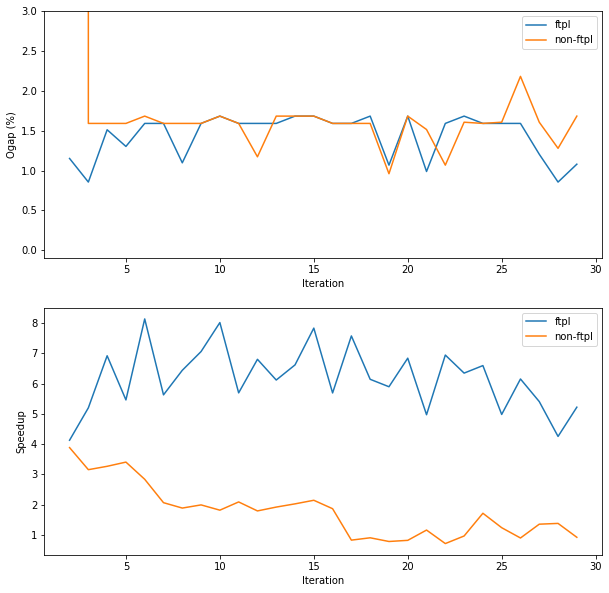

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2,1, figsize=(10,10))

offset = 2
x = np.arange(len(ftpl)-1)+2
axes[0].plot(x, [ftpl[i][0] for i in range(len(ftpl)-1)])
axes[0].plot(x, [nonftpl[i][0] for i in range(len(nonftpl))])
axes[0].set_ylim([-0.1, 3])
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Ogap (%)')

axes[0].legend(['ftpl', 'non-ftpl'])

axes[1].plot(x, [oracle_time/ftpl[i][2] for i in range(len(ftpl)-1)])
axes[1].plot(x, [oracle_time/nonftpl[i][2] for i in range(len(nonftpl))])
# axes[1].set_ylim([-0.1, 3])
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Speedup')
axes[1].legend(['ftpl', 'non-ftpl'])

In [12]:
len(ftpl)

29

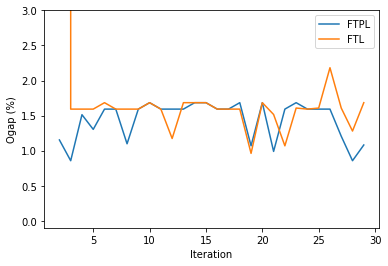

In [23]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1,1)

offset = 2
x = np.arange(len(data['ftpl']))+2
axes.plot(x, data['ftpl'] )
axes.plot(x, data['nonftpl'])
axes.set_ylim([-0.1, 3])
axes.set_xlabel('Iteration')
axes.set_ylabel('Ogap (%)')
axes.legend(['FTPL', 'FTL'])

In [24]:
fig.savefig('data/ftpl_ftl_comparison.pdf')

In [16]:
data['nonftpl']

array([5.08635571e+03, 1.59212964e+00, 1.59212964e+00, 1.59212964e+00,
       1.68380634e+00, 1.59212964e+00, 1.59212964e+00, 1.59212964e+00,
       1.68380634e+00, 1.59212964e+00, 1.17331473e+00, 1.68380634e+00,
       1.68380634e+00, 1.68380634e+00, 1.59212964e+00, 1.59212964e+00,
       1.59212964e+00, 9.61051843e-01, 1.68380634e+00, 1.51562438e+00,
       1.06860121e+00, 1.60730108e+00, 1.59212964e+00, 1.60730108e+00,
       2.18229534e+00, 1.60730108e+00, 1.27953897e+00, 1.68380634e+00])

In [26]:
(data['ftpl'])

array([1.15242853, 0.85633832, 1.51247771, 1.30336149, 1.59212964,
       1.59212964, 1.09784591, 1.59212964, 1.68380634, 1.59212964,
       1.59212964, 1.59212964, 1.68380634, 1.68380634, 1.59212964,
       1.59212964, 1.68380634, 1.06860121, 1.68380634, 0.98894928,
       1.59212964, 1.68380634, 1.59212964, 1.59212964, 1.59212964,
       1.20564006, 0.85633832, 1.08062598])

In [31]:
nonftpl

[(5086.355713752996, 3.2, 2.9489835500717163),
 (1.5921296425737657, 4.2, 3.6322306474049886),
 (1.5921296425737657, 4.133333333333334, 3.50801366964976),
 (1.5921296425737657, 4.133333333333334, 3.364587966601054),
 (1.6838063384216242, 3.8333333333333335, 4.0397932211558025),
 (1.5921296425737657, 4.166666666666667, 5.555583961804708),
 (1.5921296425737657, 4.2, 6.081245032946269),
 (1.5921296425737657, 4.466666666666667, 5.761310410499573),
 (1.6838063384216242, 5.233333333333333, 6.314946715037028),
 (1.5921296425737657, 4.7, 5.490511417388916),
 (1.1733147330830598, 5.233333333333333, 6.402869447072347),
 (1.6838063384216242, 4.666666666666667, 5.978234640757242),
 (1.6838063384216242, 4.533333333333333, 5.663325357437134),
 (1.6838063384216242, 4.266666666666667, 5.3491776069005335),
 (1.5921296425737657, 4.833333333333333, 6.1508806069691975),
 (1.5921296425737657, 4.4, 13.92465759118398),
 (1.5921296425737657, 4.366666666666666, 12.725847864151001),
 (0.9610518433903162, 6.2, 1

In [32]:
ftpl

[(1.1524285305467126, 7.933333333333334, 2.7749309460322062),
 (0.8563383223360225, 6.4, 2.202965672810872),
 (1.5124777102425426, 4.4, 1.6548226674397786),
 (1.3033614917331369, 5.166666666666667, 2.097409661610921),
 (1.5921296425737657, 4.033333333333333, 1.4071082512537638),
 (1.5921296425737657, 5.166666666666667, 2.034865077336629),
 (1.0978459071689093, 5.033333333333333, 1.7783133109410605),
 (1.5921296425737657, 4.733333333333333, 1.622014625867208),
 (1.6838063384216242, 4.233333333333333, 1.4281996011734008),
 (1.5921296425737657, 4.7, 2.011378836631775),
 (1.5921296425737657, 4.333333333333333, 1.6833046118418376),
 (1.5921296425737657, 5.1, 1.87189994653066),
 (1.6838063384216242, 4.533333333333333, 1.730306625366211),
 (1.6838063384216242, 4.3, 1.4615776538848877),
 (1.5921296425737657, 4.933333333333334, 2.012334680557251),
 (1.5921296425737657, 4.533333333333333, 1.5115286827087402),
 (1.6838063384216242, 3.8666666666666667, 1.8644436597824097),
 (1.0686012120287662, 5.

In [30]:
1/6.8/40

0.003676470588235294

In [37]:
fig.savefig('data/results/plt_compare_ftpl_nonftpl2.pdf')

In [39]:
ftpl_result = np.array([ftpl[i][0] for i in range(len(ftpl)-1)])
nonftpl_result = np.array([nonftpl[i][0] for i in range(len(ftpl)-1)])
omar_stat = {'time': omar_time, 'Ogap':3.20, 'oracle_time':oracle_time}
mydict = {'ftpl': ftpl_result, 'nonftpl': nonftpl_result, 'omar':omar_stat}
output = open('ftpl_nonftpl_validation.pkl', 'wb')
pickle.dump(mydict, output)
output.close()

In [23]:
np.argmin( [ftpl[i][0] for i in range(len(ftpl))])

7

In [5]:
filename ='ftpl_nonftpl_validation.pkl'
import pickle

with open(filename, 'rb') as handle:
    data = pickle.load(handle)
    

In [7]:
data['omar']

{'time': 0.7665881554285685, 'Ogap': 3.2, 'oracle_time': 11.455091094970703}

In [6]:
data['ftpl'] 

array([1.15242853, 0.85633832, 1.51247771, 1.30336149, 1.59212964,
       1.59212964, 1.09784591, 1.59212964, 1.68380634, 1.59212964,
       1.59212964, 1.59212964, 1.68380634, 1.68380634, 1.59212964,
       1.59212964, 1.68380634, 1.06860121, 1.68380634, 0.98894928,
       1.59212964, 1.68380634, 1.59212964, 1.59212964, 1.59212964,
       1.20564006, 0.85633832, 1.08062598])

In [10]:
import numpy as np

np.argmin(data['nonftpl'])

17

In [11]:
data['nonftpl']

array([5.08635571e+03, 1.59212964e+00, 1.59212964e+00, 1.59212964e+00,
       1.68380634e+00, 1.59212964e+00, 1.59212964e+00, 1.59212964e+00,
       1.68380634e+00, 1.59212964e+00, 1.17331473e+00, 1.68380634e+00,
       1.68380634e+00, 1.68380634e+00, 1.59212964e+00, 1.59212964e+00,
       1.59212964e+00, 9.61051843e-01, 1.68380634e+00, 1.51562438e+00,
       1.06860121e+00, 1.60730108e+00, 1.59212964e+00, 1.60730108e+00,
       2.18229534e+00, 1.60730108e+00, 1.27953897e+00, 1.68380634e+00])

In [ ]:
data

In [ ]:
mask_omar = [np.zeros(N) for _ in range(num_egs)]

t1 = time.time()

offset = 0
arguments_ml = list(zip(list(instances)[offset:], optimal_solution_list[offset:], optimal_objective_list[offset:], range(num_egs), [MODEL_FILEPATH]*num_egs, [max_ant]*num_egs, mask_omar))

out_ml =[]
for i in range(num_egs):
    output = collect_data_instance(arguments_ml[i])
    out_ml.append(output)
    

avg_ml_ogap = np.mean(np.array([out_ml[i][1] for i in range(len(out_ml))]))
avg_ml_steps = np.mean(np.array([out_ml[i][0] for i in range(len(out_ml))]))
ml_time = np.mean(np.array([out_ml[i][2] for i in range(len(out_ml))]))

# time profiling
misc_time =           np.mean(np.array([out_ml[i][4][0] for i in range(len(out_ml))]))
classification_time = np.mean(np.array([out_ml[i][4][1] for i in range(len(out_ml))]))
branching_time =      np.mean(np.array([out_ml[i][4][2] for i in range(len(out_ml))]))
classified_nodes =    np.mean(np.array([out_ml[i][4][3] for i in range(len(out_ml))]))
branched_nodes =      np.mean(np.array([out_ml[i][4][4] for i in range(len(out_ml))]))

print('Model ogap: {}, time speedup: {}'.format(avg_ml_ogap, oracle_time/ml_time))
print('BB time: {}, ML time: {} '.format(oracle_time, ml_time))